We take a look at jared's analysis of abstracts from wos on level of wos-categories.
We can select different sizes of a moving window (1-10).
We have measures of:
- the entropy
- the jsd
- the corresponding null models based on global shuffling of all word (tokens) across the abstracts of all years

We look at basic statistics and whether we can identify fields that show strong changes into either direction

In [6]:
import numpy as np
import pylab as plt
import pickle
import os,sys
# import pandas as pd
from collections import Counter
import glob

%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# pd.set_option('display.max_rows', 10)

# Read the timeseries compiled by Jared

In [9]:
path_data = os.path.abspath(os.path.join(os.pardir,'results','by-cat-results','global_null'))
print(path_data)

/DRIVE/REPOS/wos-text-dynamics/results/by-cat-results/global_null


Jared's results are saved in a textfile: 'results_<movingwindowsize>_<field>'

Each row is a separate time series in the following format: <name> \t <x(t1)>,<x(t2)>, ...

Different rows are:
- 0: ents...entropy
- 1: ent_difs...entropy difference
- 2: jsds...jensen-shannon
- 3: entropy-null_m...null model mean
- 4: entropy-null_c...null model confidence interval
- 5: entdif-null_m
- 6: entdif-null_c
- 7: jsd-null_m
- 8: jsd-null_c

Reading the timeseries of one measure for all fields:

- We create a list of all fields: list_fields
- We make a dictionary with the timeseries of all fields dict_fields['field'] = np.array('time_series')

In [149]:
n_window = 1

i=0
i_max = -1
dict_jsd = {}
list_fields = []
for filename in glob.iglob(path_data+'/results_%s_*'%(str(n_window))):
#     print(filename)

    name_field = filename.split('/')[-1][10:]
    list_fields += [name_field]
    with open(filename) as f:
        x = f.readlines()
#         x_jsd = x[2] # jsd
        x_jsd = x[7]
        ts_jsd = np.array([ float(h) for h in x_jsd.split()[-1].split(',')])
        dict_jsd[name_field] = ts_jsd
        
    i += 1
    if i==i_max:
        break
        

In [151]:
# list_fields

# plot some timeseries

Just plotting all the timeseries to get a qualitative overview on the different behaviors.
What we already observe:
- most timeseries show a systematic and slow decrease in the measured values of JSDs
- only a handful of fields show 'spiky' behavior


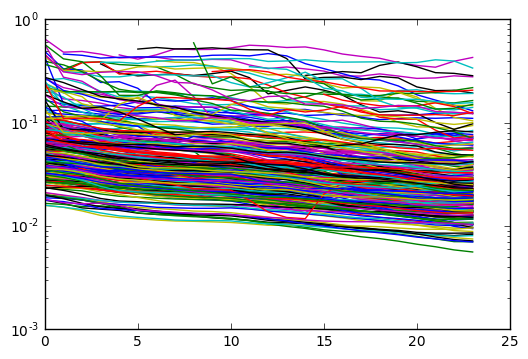

In [152]:
for field in list_fields:
    y_t = dict_jsd[field]
    plt.plot(y_t)
plt.yscale('log')

In [135]:
# list_fields

# jsd grows or declines?

We look at the average growth or decline of the JSD-measure of an individual field $s$ over time defined as:

$\Delta_s \equiv \langle Delta_s(t) \rangle = \langle y_s(t+1) - y_s(t) \rangle$,

where $y_s(t)$ is the timeseries of field s (here: the JSD)


Note that some fields have nan-values in their timeseries.

In [207]:
list_delta_jsd = []
for field in list_fields:
    y_t = dict_jsd[field]
    delta_y_t = y_t[1:] - y_t[:-1]
    delta_y_t_mu = np.mean(delta_y_t)
    
    if np.isnan(delta_y_t_mu):
    ## assign np.inf if there are nan
        delta_y_t_mu = np.inf

    list_delta_jsd += [delta_y_t_mu]

In [178]:
len(list_fields)

238

In [208]:
# make a masked array to account for nan-values
x_mask = np.ma.masked_array(np.array(list_delta_jsd),mask=np.array(list_delta_jsd) == np.inf)#, np.inf)

(-0.05, 0.05)

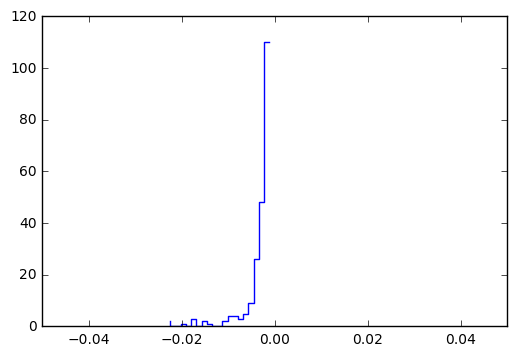

In [211]:
## note that histogram cannot cope with masked arrays, so we do compress to 'delete' the masked values
h,bins = plt.histogram(x_mask.compressed(),bins=20)
plt.step(bins[:-1],h)
plt.xlim(-0.05,0.05)

### Discussion

The above histogram is rather troubling.

- the distribution is asymmetric; so there seems to be a (spurious) difference between a field accelerating or decelrating
- all measured values of $\langle \Delta_s \rangle <0$ seem to indicate that all fields are slowing down in their language evolution. I think this is an artefact of the measurement - most likely due to the fact that the amount of data is increasing. this might indicate that we are not suffieciently taking into account the bias (or database size dependence).

Suggestions/Ideas:
- take other measure which is more robust, e.g. changing the $\alpha$ - parameter
- the null model is too weak; we already discussed that we might have to try a 'local' shuffling where we only shuffle the tokens between the years we are actually comparing.
- introduce a cutoff on the number of types to include, e.g. only compare the top-10,000 word types of each year
- subsample data from later years
- ...
